In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm

In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

## More data cleaning and experimentation

In [3]:
file_name = "/Users/dafirebanks/Downloads/SongCSV.csv"
df = pd.read_csv(file_name)

In [4]:
df = df.fillna(0)

In [5]:
df.columns

Index(['SongNumber', 'SongID', 'AlbumID', 'AlbumName', 'ArtistFamiliarity',
       'ArtistHotttnesss', 'ArtistID', 'ArtistLatitude', 'ArtistLocation',
       'ArtistLongitude', 'ArtistName', 'BarsConfidence', 'BarsStart',
       'BeatsConfidence', 'BeatsStart', 'Danceability', 'Duration',
       'EndOfFadeIn', 'Energy', 'KeySignature', 'KeySignatureConfidence',
       'Loudness', 'Mode', 'ModeConfidence', 'SectionsConfidence',
       'SectionsStart', 'SegmentsConfidence', 'SegmentsLoudnessMax',
       'SegmentsLoudnessMaxTime', 'SegmentsLoudnessMaxStart',
       'SegmentsPitches', 'SegmentsStart', 'SegmentsTimbre', 'SongHotttnesss',
       'TatumsConfidence', 'TatumsStart', 'Tempo', 'TimeSignature',
       'TimeSignatureConfidence', 'Title', 'Year'],
      dtype='object')

In [7]:
# Columns that have lists as values
list_columns = ["BarsConfidence", "BarsStart", "BeatsConfidence", "BeatsStart", "SectionsConfidence", "SectionsStart", 
                "SegmentsConfidence", "SegmentsLoudnessMax", "SegmentsLoudnessMaxTime", "SegmentsLoudnessMaxStart", 
                "SegmentsStart", "TatumsConfidence", "TatumsStart"]

In [8]:
def transform_str_to_list(df, columns):
    for col in columns:
        all_cells = []
        
        # Modify each cell 
        for i in range(0, len(df[col])):
            
            # Get list
            horrid_string = df[col][i]
            
            # Remove non-float values
            pretty_string = horrid_string.replace("[", "").replace("]", "").replace("...", "")
            
            # Convert to a list of floats
            pretty_list = pretty_string.split()
            try:
                beautiful_list = np.array([float(el) for el in pretty_list])
            except:
                print(col, i)
                print(pretty_list)
            
            # Add to list of cells
            all_cells.append(beautiful_list)
        
        # Make it a new column
        df[col] = pd.Series(all_cells)

In [9]:
transform_str_to_list(df, list_columns)

In [11]:
# Transform all arrays to the minimum
def reduce_arrays(col_name):
    col = df[col_name]
    
    min_len = len(col[0])
    
    # Get minimum length 
    for i in range(len(col)):
        cell = col[i]
        
        # Check that the list is not empty and that all the elements are not 0
        if len(cell) < min_len and len(cell) != 0 and not all(v == 0.0 for v in cell):    
            min_len = len(cell)
#             print(i, len(cell), cell)

#     print("Minimum length is", min_len)
        
    # Transform all arrays in the column to the minimum length
    for i in tqdm(range(len(col))):
        cell = col[i]
        
        # If we stumble upon a zero array or an empty array...
        if len(cell) == 0 or len(cell) < min_len:
            col[i] = np.zeros(min_len)
        else: # We get the first min_len elements
            col[i] = col[i][:min_len]
    
    return col

In [12]:
# Make all the lists in the columns to be the same length (the length of the smallest list)
for name in list_columns:
    df[name] = reduce_arrays(name)

  0%|          | 0/10000 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  0%|          | 32/10000 [00:00<05:39, 29.36it/s]/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
100%|██████████| 10000/10000 [04:15<00:00, 39.08it/s]


In [13]:
df.to_csv("Clean_Songs.csv") 

## Building models!
### Data prep

In [95]:
# 2 dataframes: 1 with list averages, and the other one with uniform length lists
list_df = pd.read_csv("Clean_Songs.csv")
average_df = pd.read_csv("average_df.csv")

In [96]:
# Drop unnecessary columns
list_df = list_df.drop(columns=["Unnamed: 0"])
average_df = average_df.drop(columns=["Unnamed: 0", "Energy", "SegmentsPitches", "SegmentsTimbre", 'SongID', 'SongNumber', 'AlbumName', 'AlbumID', 'ArtistID', 
                              'ArtistLocation', 'ArtistName', 'Title'])

In [97]:
# Choose one of the dfs to work with, choose is_listdf to be True or False accordingly
df = list_df
is_listdf = True 

In [102]:
# If we want to use list data, make the list part of the observation rather than having a list of lists
def flatten_lists(data):
    new_data = []
    
    for obs in data:
        new_el = []
        for el in obs:
            if isinstance(el, str):
                corrected_els = [float(e) for e in el.replace("]", "").replace("[", "").split()]
                new_el.extend(corrected_els)
            else:
                new_el.append(el)
        
        new_data.append(new_el)
    
    return np.array(new_data)

In [103]:
# PREPROCESSING!!!!!

# Make the target variable binary 
# TODO What if we make this above average rather than 0.5
df["SongHotttnesss"] = pd.Series([1 if i > 0.5 else 0 for i in df["SongHotttnesss"]])

# Target variable index
tg_idx = df.columns.get_loc("SongHotttnesss")

# Get your X and y
numeric_data = df.values
y = numeric_data[:, tg_idx].astype(float)
X = np.delete(numeric_data, tg_idx, 1)

# Flatten lists IF USING DF 
if is_listdf:
    X = flatten_lists(X)

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

(10000, 64) (10000,)


In [152]:
# Method to test any classifier and print metrics
def test_classifier(clf, X_test, y_test, grid_search=False):
    preds = clf.predict(X_test)
    
    # Normal metrics
    print("GENERAL METRICS:")
    print("Accuracy: ", metrics.accuracy_score(y_test, preds))
    print("Precision: ", metrics.precision_score(y_test, preds))
    print("Recall: ", metrics.recall_score(y_test, preds))
    print("F1 score: ", metrics.f1_score(y_test, preds))
    print()
    print(classification_report(y_test, preds))
    print()
    
    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    print("Original Confusion Matrix")
    print(cm)
    print()
    
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plot_confusion_matrix(cm, classes=['Not Hot','Hot'], normalize=True,
                          title='Confusion matrix')
    
    print()
    print("ROC curve + Confusion matrix")
    
    # ROC curve (from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python)
    pred_probs = clf.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test,  pred_probs)
    auc = roc_auc_score(y_test, pred_probs)
    plt.subplot(1, 2, 2)
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.legend(loc=4)
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=None)
    
    plt.show()
    
    # Best parameters
    if grid_search:
        print("Best parameters for classifier are:")
        print(gs_rf.best_params_)
    
    return preds

In [119]:
# CODE TAKEN FROM SKLEARN CONFUSION MATRIX PAGE! -> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


### Random Forest

In [106]:
# Model
rf = RandomForestClassifier(random_state=42)

In [107]:
rf_params = {'max_depth':[3, 8, 15, 20], 'class_weight':["balanced", "balanced_subsample"], "min_samples_split":[2, 5, 7], "criterion":["gini", "entropy"]}
gs_rf = GridSearchCV(rf, param_grid=rf_params, cv=10, scoring="f1")

In [108]:
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 8, 15, 20], 'class_weight': ['balanced', 'balanced_subsample'], 'min_samples_split': [2, 5, 7], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

GENERAL METRICS:
Accuracy:  0.774
Precision:  0.4104979811574697
Recall:  0.7060185185185185
F1 score:  0.5191489361702127

             precision    recall  f1-score   support

        0.0       0.93      0.79      0.85      2068
        1.0       0.41      0.71      0.52       432

avg / total       0.84      0.77      0.79      2500


Original Confusion Matrix
[[1630  438]
 [ 127  305]]

Normalized confusion matrix
[[0.78820116 0.21179884]
 [0.29398148 0.70601852]]

ROC curve + Confusion matrix


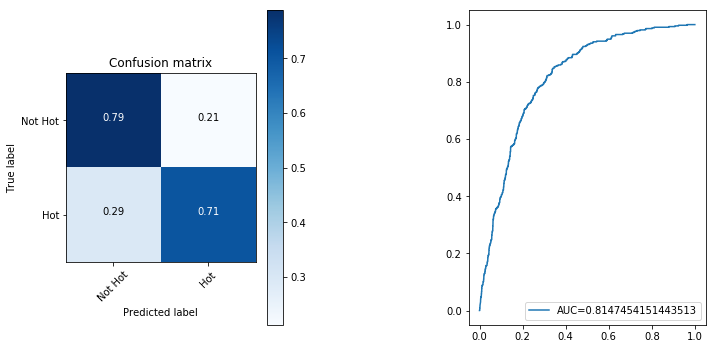

Best parameters for classifier are:
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 5}


In [153]:
gsrf_preds = test_classifier(gs_rf, X_test, y_test, grid_search=True)

### Gradient Boosting

In [144]:
from sklearn.ensemble import GradientBoostingClassifier

In [166]:
gb = GradientBoostingClassifier(random_state=42)#(n_estimators=500, random_state=0, max_depth=8)
# gb.fit(X_train, y_train)

In [170]:
# Experimenting with params
gb_params = {"criterion": ["friedman_mse", "mse"], "learning_rate":[0.001, 0.01, 0.1], 
             "max_depth":list(range(3,16,2)), "min_samples_split":list(range(2, 100, 3)), 
             "n_estimators":list(range(100, 1000, 200)), "max_features":list(range(1,X_train.shape[1]))}

gs_gb = GridSearchCV(gb, param_grid=gb_params, cv=10, scoring="f1")

In [ ]:
gs_gb.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-sco

GENERAL METRICS:
Accuracy:  0.8328
Precision:  0.5324074074074074
Recall:  0.2662037037037037
F1 score:  0.3549382716049383

             precision    recall  f1-score   support

        0.0       0.86      0.95      0.90      2068
        1.0       0.53      0.27      0.35       432

avg / total       0.80      0.83      0.81      2500


Original Confusion Matrix
[[1967  101]
 [ 317  115]]

Normalized confusion matrix
[[0.95116054 0.04883946]
 [0.7337963  0.2662037 ]]

ROC curve + Confusion matrix


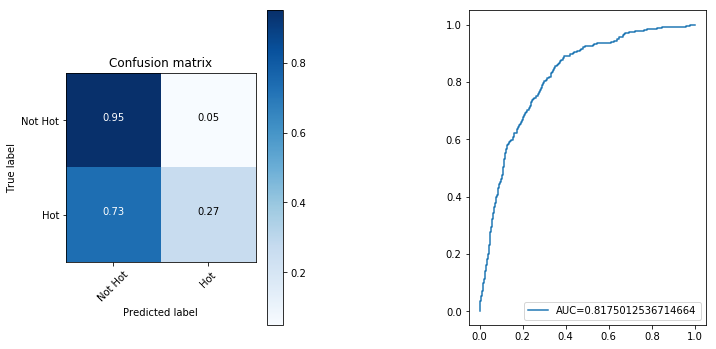

In [154]:
gsgb_preds = test_classifier(gs_gb, X_test, y_test, grid_search=True)

In [ ]:
set(y_test) - set(gsgb_preds)

### AdaBoost

In [155]:
from sklearn.ensemble import AdaBoostClassifier

In [156]:
ab = AdaBoostClassifier(n_estimators=500, random_state=0)
ab.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=500, random_state=0)

GENERAL METRICS:
Accuracy:  0.8236
Precision:  0.48464163822525597
Recall:  0.3287037037037037
F1 score:  0.3917241379310345

             precision    recall  f1-score   support

        0.0       0.87      0.93      0.90      2068
        1.0       0.48      0.33      0.39       432

avg / total       0.80      0.82      0.81      2500


Original Confusion Matrix
[[1917  151]
 [ 290  142]]

Normalized confusion matrix
[[0.92698259 0.07301741]
 [0.6712963  0.3287037 ]]

ROC curve + Confusion matrix


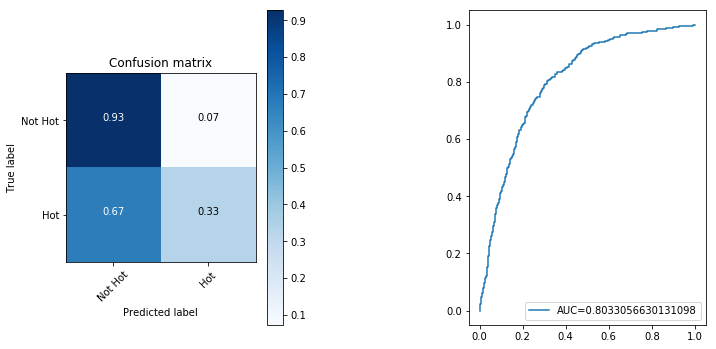

In [157]:
ab_preds = test_classifier(ab, X_test, y_test, grid_search=False)

### Testing threshold values

In [164]:
# Code from homework 5
def modified_f1(threshold):
    def f1_threshold(clf, X, y):
        y_pred = predict_with_threshold(clf, X, threshold)
        return metrics.f1_score(y, y_pred)
        
    return f1_threshold

def predict_with_threshold(clf, X, threshold):    
    pred_probs = clf.predict_proba(X)
    decision = [1 if p > threshold else 0 for p in pred_probs[:,1]]
    
    return decision

# Method to test multiple threshold values for prediction
def test_threshold_values(t_values, clf, X, y):
    results = []
    
    for t in tqdm(t_values):
        result = cross_val_score(clf, X, y, scoring=modified_f1(t), cv=10)
        results.append(result)
    
    # PLOT THRESHOLD VALUES FOR PREDICTION AGAINST F1 SCORE! (Code from homework 5)
    sns.boxplot(x=t_values, y=results)
    plt.xlabel("Threshold Values")
    plt.ylabel("Scores")
    plt.title("Cross validation scores per threshold values")
    plt.show()
    
    # FEATURE IMPORTANCE PER CLASSIFIER (Code from homework 5)
    feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = reds.columns[:-1],
                                    columns=['importance']).sort_values('importance', ascending=False)
    feature_importances.plot.bar().show()
    
    return results

In [ ]:
t_values = [0.2, 0.5]#[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
scores = test_threshold_values(t_values, gs_rf, X_test, y_test)

## TODO: Testing with oversampling and undersampling

In [ ]:
from sklearn.utils import resample

In [ ]:
# Code taken from https://towardsdatascience.com/comparing-different-classification-machine-learning-models-for-an-imbalanced-dataset-fdae1af3677f

# MODIFY THIS
df_majority_downsample = resample(df_majority, 
                                 replace=True,     
                                 n_samples=105,    
                                 random_state=123) 

df_train = pd.concat([df_majority_downsample, df_minority_upsampled])